# Data is for Good : Concours sur la Smart City
Optimisation des tournées pour l'entretien des arbres de la ville de Paris

## 1. Installation de l'environnement virtuel et des librairies

### A. Environnement virtuel 

La liste de dépendances avec la version se trouve dans le fichier ```requirements.txt```.

Pour installer les dépendances nécessaires (Windows): 

1. Se rendre dans le répertoire du projet
2. Créer l'environnement virtuel via ```python -m venv environnement/```
3. Activer l'environnement virtuel via ```.\environnement\Scripts\activate```
4. Installer les dépendances via ```pip install -r requirements.txt```
5. Exporter les dépendances via ```pip freeze > requirements.txt```

Desactivez l'environnement virtuel avec la commande ```deactivate```

### B. Librairies

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno

sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

## 2. Présentation générale du jeu de données

### A. Importation des données

In [3]:
df = pd.read_csv('p2-arbres-fr.csv', sep=';')
df.head()

id type_emplacement domanialite   arrondissement complement_addresse  \
0  99874            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
1  99875            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
2  99876            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
3  99877            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
4  99878            Arbre      Jardin  PARIS 17E ARRDT                 NaN   

   numero                                        lieu id_emplacement  \
0     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             19   
1     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             20   
2     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             21   
3     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             22   
4     NaN  PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING       000G0037   

  libelle_francais      genre         espece variete  circonference_cm  \
0       Marronnier   Aesculus  hippocastanum     NaN                20   
1               If      Taxus        baccata     NaN                65   
2               If      Taxus        baccata     NaN                90   
3           Erable       Acer        negundo     NaN                60   
4     Arbre à miel  Tetradium      daniellii     NaN                38   

   hauteur_m stade_developpement  remarquable  geo_point_2d_a  geo_point_2d_b  
0          5                 NaN          0.0       48.857620        2.320962  
1          8                   A          NaN       48.857656        2.321031  
2         10                   A          NaN       48.857705        2.321061  
3          8                   A          NaN       48.857722        2.321006  
4          0                 NaN          NaN       48.890435        2.315289

In [4]:
df.columns

Index(['id', 'type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'numero', 'lieu', 'id_emplacement',
       'libelle_francais', 'genre', 'espece', 'variete', 'circonference_cm',
       'hauteur_m', 'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b'],
      dtype='object')

In [5]:
df["type_emplacement"].unique()

array(['Arbre'], dtype=object)

In [6]:
df.shape

(200137, 18)

Notre jeu de données contient 200137 lignes (200136 arbres) et 18 colonnes ou variables : 

* ```id``` : l'ID unique de l'arbre
* ```type_emplacement``` : tous les individus de cette variable ont la même valeur, "Arbre", nous ne pouvons pas exploiter ce variable
* ```domanialite``` : la domanialité d'un arbre, jardin, alignement, cimetière, etc.
* ```arrondissement``` 
* ```complement_adresse``` 
* ```numero``` : NaN sur toute la colonne, variable à supprimer
* ```lieu``` : l'adresse de chaque arbre
* ```id_emplacement``` 
* ```libelle_francais``` : ex. Marronnier, Arbre à Miel, Tilleul, etc.
* ```genre``` : ex. Aesculus, Tetradium, Platanus, etc.
* ```espece``` : l'espèce de l'arbre
* ```variete``` : la variété de l'arbre
* ```circonference_cm``` : la circonférence de l'arbre en centimètres
* ```hauteur_m``` : la hauteur de l'arbre en mètres
* ```stade_developpement``` : le stade de développement (jeune, jeune adulte, adulte, mature)
* ```remarquable``` : si l'arbre est rémarquable ou pas
* ```geo_point_2d_a, geo_point_2d_b``` : les coordonées géographiques de l'arbre

### B. Les types de données

In [7]:
df.dtypes

id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object

In [8]:
df["remarquable"].unique()

array([ 0., nan,  1.])

Les types de variable sont ceux qui sont attendus. Il y a des variables numériques et non-numériques (object: texte).  
La variable ```remarquable``` pourrait être un boolean, à la place nous avons soit 1.0 pour vrai et 0.0 pour faux, ainsi que quelques valeurs NaN. Nous allons la transformer en boolean par la suite.

## 3. Démarche méthodologique d'analyse de données 

### A. Valeurs aberrantes/atypiques

#### Detection des valeurs aberrantes avec l'écart inter-quartile

In [9]:
Q1 = df[["circonference_cm", "hauteur_m"]].quantile(0.25)
Q3 = df[["circonference_cm", "hauteur_m"]].quantile(0.75)
EI = Q3 - Q1
EI

circonference_cm    85.0
hauteur_m            7.0
dtype: float64

In [10]:
lim_inf = Q1 - 1.5*EI
lim_sup = Q3 + 1.5*EI

print(lim_inf)
print(lim_sup)

circonference_cm   -97.5
hauteur_m           -5.5
dtype: float64
circonference_cm    242.5
hauteur_m            22.5
dtype: float64


Une aberration est possible à partir de 242.5cm de circonférence ou 22.5m de hauteur.

In [11]:
outliers = (df[["circonference_cm", "hauteur_m"]] < lim_inf) | (df[["circonference_cm", "hauteur_m"]] > lim_sup)

circ_outliers = outliers[outliers["circonference_cm"] == True].count()
hauteur_outliers = outliers[outliers["hauteur_m"] == True].count()

percent_circ = ((circ_outliers["circonference_cm"] / 200136)*100)
percent_hauteur = ((hauteur_outliers["hauteur_m"] / 200136)*100)

print(f"Circonference = {percent_circ}\nHauteur = {percent_hauteur}")

Circonference = 1.7033417276252147
Hauteur = 1.950173881760403


1.7% de nos circonférences sont des outliers. 1.95% de nos hauteurs sont de soutliers.

#### Hauteur

D'après le site du Ministère de l'Agriculture, l'arbre le plus haut de Paris mésure 30m de haut. Mais, dans notre jeu de données, il existe 558 arbres à Paris dont la hauteur dépasse 30m, dont la valeur la plus aberrante est l'arbre avec une hauteur de 800000m.  
La proposition est de remplacer simplement les valeurs atypiques et aberrantes par la médiane.

Text(0.5, 0, 'Hauteur en mètres')

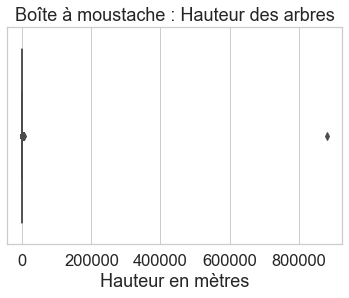

In [12]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

hauteur_boxplot = sns.boxplot(x=df['hauteur_m'])
hauteur_boxplot.set_title("Boîte à moustache : Hauteur des arbres")
hauteur_boxplot.set_xlabel("Hauteur en mètres")

In [13]:
df_clean = df

df_mask = df_clean['hauteur_m']>31
filtered_df = df_clean[df_mask].count()
print(filtered_df["id"])

558


In [14]:
median_h_sd = df_clean.groupby('stade_developpement')["hauteur_m"].median().sort_values(ascending=True)
hauteur_median = df_clean["hauteur_m"].median()
print(median_h_sd[0],median_h_sd[1],median_h_sd[2], median_h_sd[3])

5.0 9.0 12.0 20.0


In [15]:
df_clean["hauteur_m"] = np.where(
    (df_clean["hauteur_m"] > 31) & (df_clean["stade_developpement"]=="J"), median_h_sd[0], df_clean["hauteur_m"]
)

df_clean["hauteur_m"] = np.where(
    (df_clean["hauteur_m"] > 31) & (df_clean["stade_developpement"]=="JA"), median_h_sd[1], df_clean["hauteur_m"]
)

df_clean["hauteur_m"] = np.where(
    (df_clean["hauteur_m"] > 31) & (df_clean["stade_developpement"]=="A"), median_h_sd[2], df_clean["hauteur_m"]
)

df_clean["hauteur_m"] = np.where(
    (df_clean["hauteur_m"] > 31) & (df_clean["stade_developpement"]=="M"), median_h_sd[3], df_clean["hauteur_m"]
)

df_clean["hauteur_m"] = np.where(
    (df_clean["hauteur_m"] > 31) & (df_clean["stade_developpement"].isnull()), hauteur_median, df_clean["hauteur_m"]
)

Text(0.5, 0, 'Hauteur en mètres')

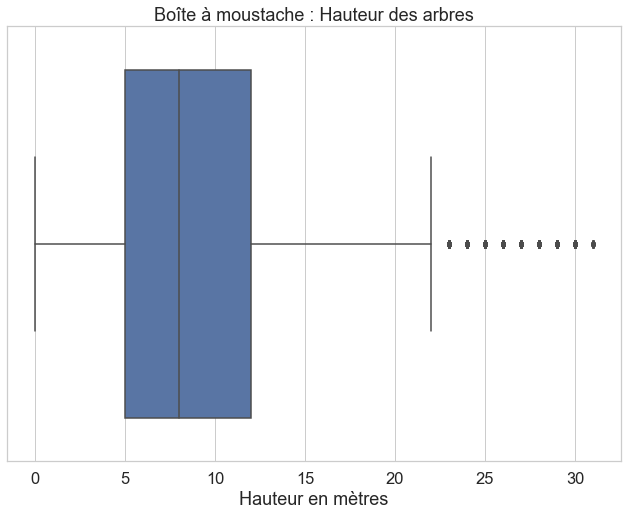

In [16]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
hauteur_boxplot = sns.boxplot(x=df_clean['hauteur_m'])
hauteur_boxplot.set_title("Boîte à moustache : Hauteur des arbres")
hauteur_boxplot.set_xlabel("Hauteur en mètres")


#### Circonférence

La circonférence du plus grand arbre de Paris est de 800cm. Nous pouvons donc procéder de la même manière qu'avec la variable ```hauteur_m``` en nettoyant toutes les valeurs qui dépassent par ex. 810cm.

Text(0.5, 0, 'Circonférence en centimètres')

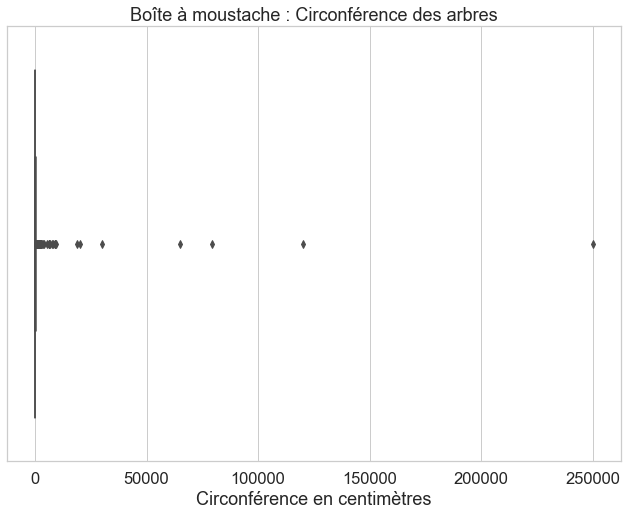

In [17]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
circonference_boxplot = sns.boxplot(x=df_clean['circonference_cm'])
circonference_boxplot.set_title("Boîte à moustache : Circonférence des arbres")
circonference_boxplot.set_xlabel("Circonférence en centimètres")

In [18]:
df_mask = df_clean['circonference_cm']>810
filtered_df = df[df_mask].count()
print(filtered_df["id"])

77


In [19]:
median_c_sd = df_clean.groupby('stade_developpement')["circonference_cm"].median().sort_values(ascending=True)
circ_median = df_clean["circonference_cm"].median()
print(median_c_sd[0],median_c_sd[1],median_c_sd[2], median_c_sd[3])

35.0 65.0 115.0 215.0


In [20]:
df_clean["circonference_cm"] = np.where(
    (df_clean["circonference_cm"] > 810) & (df_clean["stade_developpement"]=="J"), median_c_sd[0], df_clean["circonference_cm"]
)

df_clean["circonference_cm"] = np.where(
    (df_clean["circonference_cm"] > 810) & (df_clean["stade_developpement"]=="JA"), median_c_sd[1], df_clean["circonference_cm"]
)

df_clean["circonference_cm"] = np.where(
    (df_clean["circonference_cm"] > 810) & (df_clean["stade_developpement"]=="A"), median_c_sd[2], df_clean["circonference_cm"]
)

df_clean["circonference_cm"] = np.where(
    (df_clean["circonference_cm"] > 810) & (df_clean["stade_developpement"]=="M"), median_c_sd[3], df_clean["circonference_cm"]
)

df_clean["circonference_cm"] = np.where(
    (df_clean["circonference_cm"] > 810) & (df_clean["stade_developpement"].isnull()), circ_median, df_clean["circonference_cm"]
)

Text(0.5, 0, 'Circonférence en centimètres')

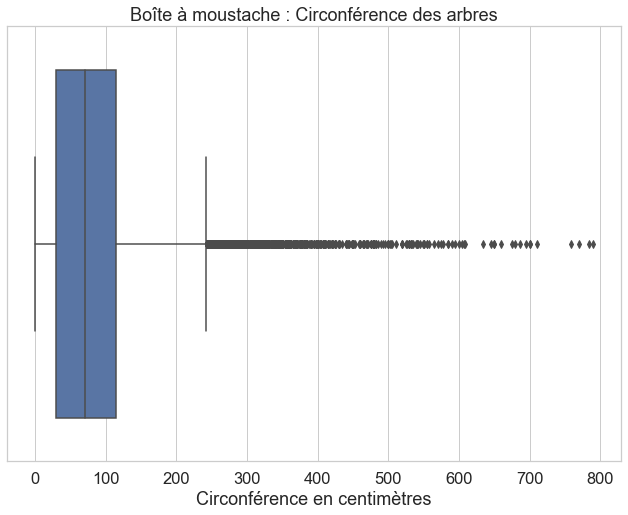

In [21]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
circonference_boxplot = sns.boxplot(x=df_clean['circonference_cm'])
circonference_boxplot.set_title("Boîte à moustache : Circonférence des arbres")
circonference_boxplot.set_xlabel("Circonférence en centimètres")

#### hauteur_m = 0, circonference_cm = 0

Il y a 25501 arbres dans notre jeu de données dont la hauteur est 0m et la circonférence est 0cm. Si le stade de développement est renseigné, nous pouvons éstimer la hauteur et la circonférence de l'arbre grâce aux moyennes de chaque groupe (jeune, adulte, etc.).

In [22]:
df_c_h_0 = df_clean[(df_clean["hauteur_m"]==0) & (df_clean["circonference_cm"]==0)]
df_c_h_0["id"].count()

25501

In [23]:
print(df_c_h_0.groupby("stade_developpement").size())

stade_developpement
A      56
J     122
JA     37
M      22
dtype: int64


<AxesSubplot:>

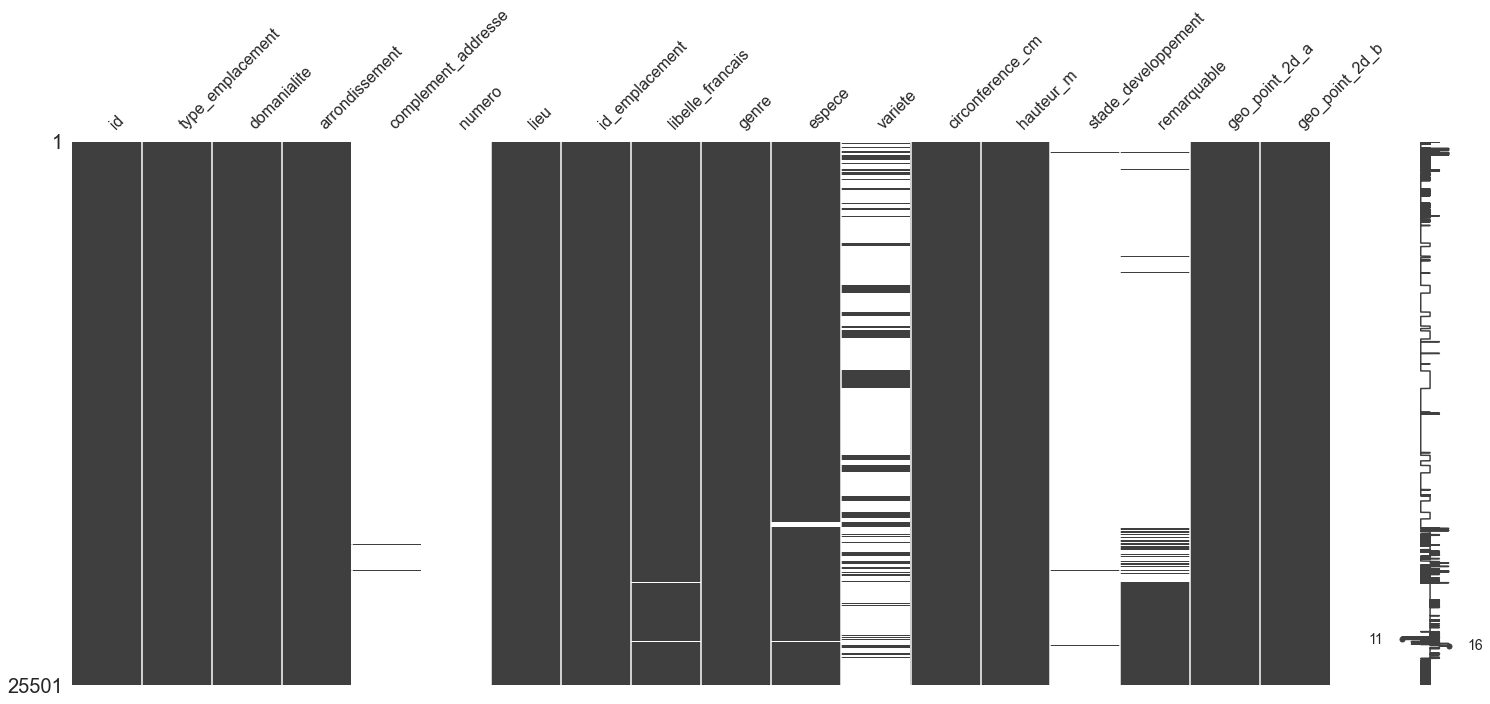

In [24]:
missingno.matrix(df_c_h_0)

Malheureusement, il manque trop de données pour essayer de renseigner les valeurs manquantes. Les arbres de hauteur et circonférence 0 corréspondent aux environ 20000 arbres plantés à Paris cet hiver dans le cadre de l'objectif Plan Arbre detaillé sur le site de la ville de Paris.  
Il faudra remplacer les valeurs anormales (0) par NaN afin que ces valeurs n'influencent pas le résultat de l'analyse.

In [25]:
df_clean["hauteur_m"] = np.where(
    (df_clean["hauteur_m"]==0), np.nan, df_clean["hauteur_m"]
)
df_clean["circonference_cm"] = np.where(
    (df_clean["circonference_cm"]==0), np.nan, df_clean["circonference_cm"]
)

### B. Valeurs manquantes

<AxesSubplot:>

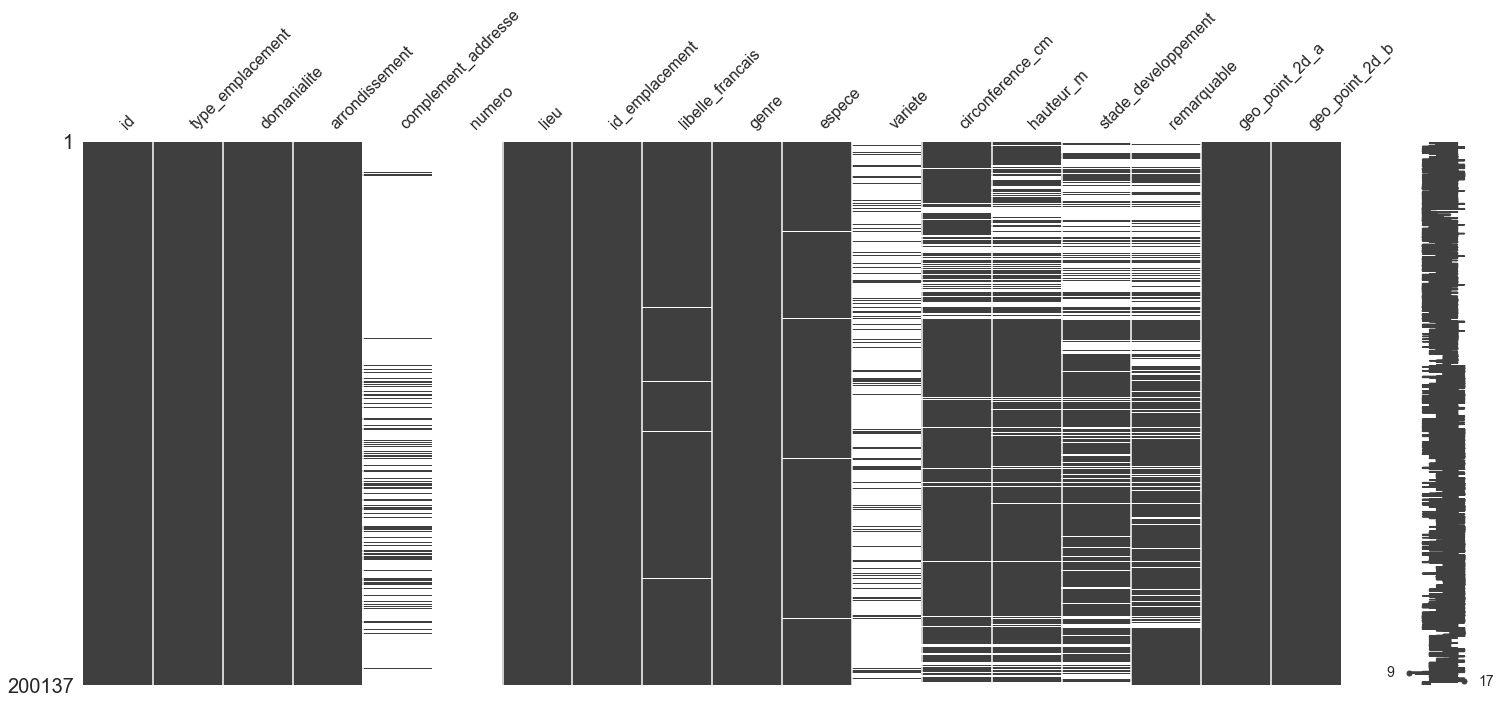

In [26]:
missingno.matrix(df_clean)

<AxesSubplot:>

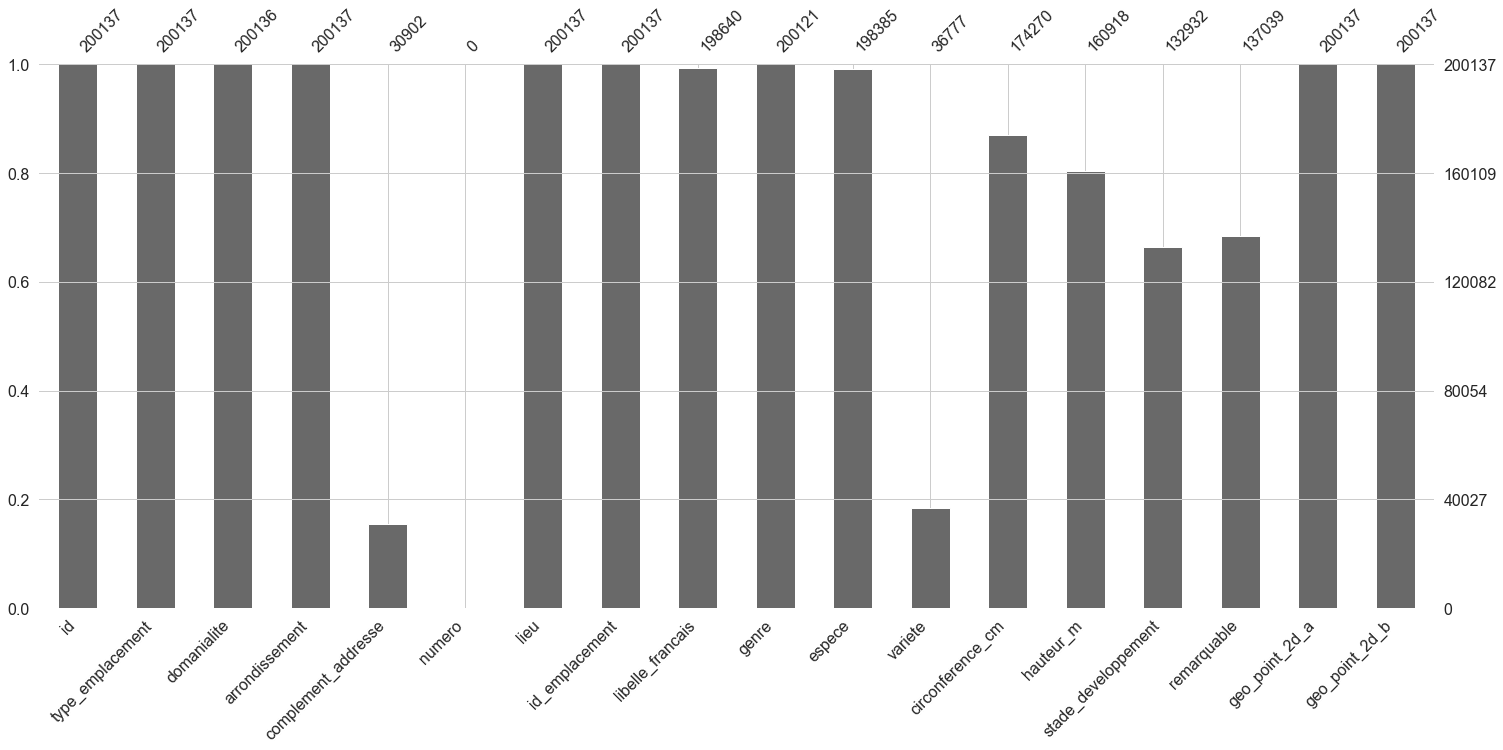

In [27]:
missingno.bar(df_clean)

In [28]:
df.isna().sum()

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm        25867
hauteur_m               39219
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

Sur 200137 individus (arbres), il nous manque : 
* Le complément d'adresse pour 169235 individus. Ce n'est pas grave, pas toutes les adresses contiennent un complément. 
* Le numéro pour tous les individus individus. À supprimer.
* Le libellé français sur 1497 individus, l'espèce sur 1752 individus et la variété sur 163360 individus. Nous pourrons utiliser le genre ou le libellé français pour nos analyses puisque c'est le variable pour lequel il manque le moins de données. 
* Le stade de développement manque pour 67205 individus : nous pouvons estimer cette donnée grâce à la hauteur et la circonférence de l'arbre. 
* Le variable rémarquable manque pour 63098 individus : environ 200 arbres rémarquables à paris. Nous pouvons supposer que les 63k ne sont pas remarquables et remplacer ainsi les valeurs manquantes.

### Nettoyage des valeurs manquantes

##### Elimination de la colonne "numero" 

Puisqu'il n'y a pas de valeurs pour le variable "numero", cette variable peut être supprimée. Nous ne pouvons pas en servir pour l'analyse.  


In [29]:
df_clean = df.drop("numero",axis=1) # j'elimine la colonne "numero", le dataframe nettoyé sous le variable #df_clean
df_clean.shape #je vérifie qu'il y a maintenant 17 colonnes au lieu de 18

(200137, 17)

##### Nettoyage du variable "remarquable"
Il faut remplacer les valeurs manquantes par 0.0, ce qui corréspond à "arbre non-remarquable". Nous pouvons supposer que toutes les arbres remarquables ont été marqués avec un 1.0 dans le dataframe.

In [30]:
df.loc[df['remarquable']==1.0]["id"].shape  # il y a 184 arbres remarquables dans notre dataframe
                                            # ce qui correspond à notre information d'environ
                                            # 200 arbres remarquables à Paris


(184,)

In [31]:
df_clean["remarquable"] = df_clean["remarquable"].fillna(0.0) # remplacer NaN par 0.0 pour variable "remarquable"
df_na_remarquable = df_clean["remarquable"].isnull().sum() 
print(df_na_remarquable) # vérifier qu'il n'y a plus de valeur manquante pour le var "remarquable"

0


In [32]:
df_clean["remarquable"].unique() # vérifier qu'il n'y a pas d'erreur d'irregularité ou lexicale

array([0., 1.])

In [33]:
df_clean["remarquable"].replace({0. : False, 1. : True}, inplace=True)
df_clean["remarquable"].unique()

array([False,  True])

##### Nettoyage de la variable "stade_developpement"

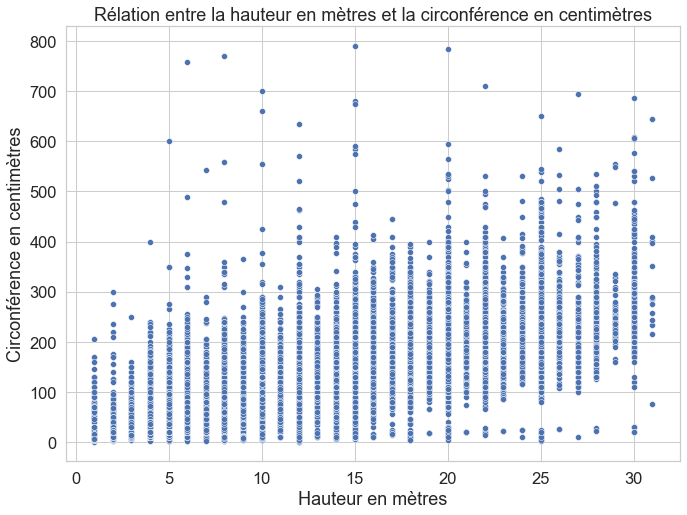

In [34]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
sns.scatterplot(x=df_clean["hauteur_m"], y=df_clean["circonference_cm"])
plt.xlabel("Hauteur en mètres")
plt.ylabel("Circonférence en centimètres")
plt.title("Rélation entre la hauteur en mètres et la circonférence en centimètres")
plt.show()

Pour éviter de perdre 67205 valeurs dans la variable ```stade_developpement```, puisqu'il y a une rélation linéaire entre la hauteur et la circonférence, nous pouvons éstimer le stade de développement à l'aide d'un des deux variables.  
  
Cette estimation n'est pas complétement exacte car chaque espèce d'arbre est unique et a des caractéristiques différentes. Nous avons la possibilité d'obtenir une valeur plus exacte en étudiant la corrélation entre stade_developpement, hauteur_m, circonference_cm et espèce si un jour une estimation plus exacte nous interesserait. 

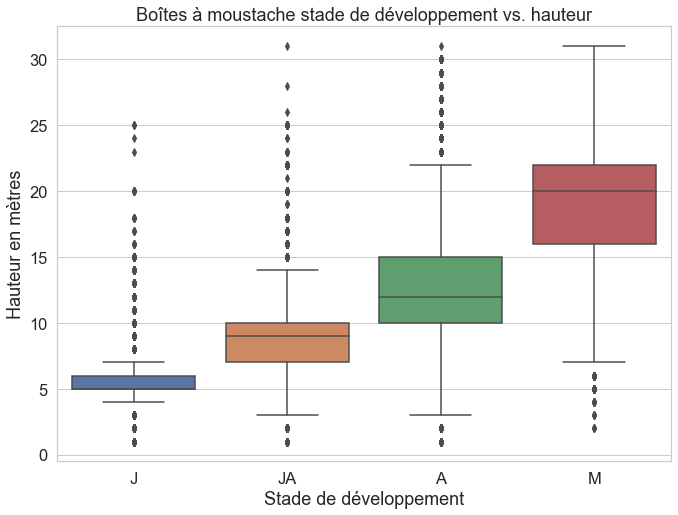

In [35]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
sorted_nb = df_clean.groupby(["stade_developpement"])["hauteur_m"].median().sort_values()
sns.boxplot(x=df_clean["stade_developpement"], y=df_clean["hauteur_m"], order=list(sorted_nb.index))

plt.xlabel("Stade de développement")
plt.ylabel("Hauteur en mètres")
plt.title("Boîtes à moustache stade de développement vs. hauteur")
plt.show()


In [36]:
df_clean[df_clean["stade_developpement"] == "J"].describe()

id  circonference_cm     hauteur_m  geo_point_2d_a  \
count  2.693700e+04      26811.000000  26463.000000    26937.000000   
mean   5.551973e+05         38.687069      5.758304       48.851984   
std    6.932945e+05         18.856549      2.064508        0.024666   
min    9.988400e+04          1.000000      1.000000       48.759069   
25%    2.067940e+05         25.000000      5.000000       48.833242   
50%    2.402390e+05         35.000000      5.000000       48.847313   
75%    2.914600e+05         45.000000      6.000000       48.869577   
max    2.023252e+06        355.000000     25.000000       48.910713   

       geo_point_2d_b  
count    26937.000000  
mean         2.353568  
std          0.051922  
min          2.212541  
25%          2.315492  
50%          2.349694  
75%          2.390117  
max          2.469759

In [37]:
df_clean[df_clean["stade_developpement"] == "JA"].describe()

id  circonference_cm     hauteur_m  geo_point_2d_a  \
count  3.544400e+04      35393.000000  34867.000000    35444.000000   
mean   3.634049e+05         70.353827      9.055210       48.854241   
std    4.689381e+05         28.315324      3.212429        0.023929   
min    1.005450e+05          4.000000      1.000000       48.742290   
25%    2.092888e+05         52.000000      7.000000       48.836690   
50%    2.421920e+05         65.000000      9.000000       48.853149   
75%    2.777322e+05         85.000000     10.000000       48.870452   
max    2.023255e+06        790.000000     31.000000       48.910689   

       geo_point_2d_b  
count    35444.000000  
mean         2.344254  
std          0.047973  
min          2.212229  
25%          2.306372  
50%          2.345472  
75%          2.379510  
max          2.469718

In [38]:
df_clean[df_clean["stade_developpement"] == "A"].describe()

id  circonference_cm     hauteur_m  geo_point_2d_a  \
count  6.443800e+04      64357.000000  63247.000000    64438.000000   
mean   3.615459e+05        122.293364     13.102724       48.857050   
std    4.728249e+05         45.758258      4.443423        0.024753   
min    9.987500e+04          1.000000      1.000000       48.742371   
25%    1.992020e+05         90.000000     10.000000       48.840100   
50%    2.477445e+05        115.000000     12.000000       48.857773   
75%    2.798838e+05        150.000000     15.000000       48.873826   
max    2.023308e+06        759.000000     31.000000       48.911050   

       geo_point_2d_b  
count    64438.000000  
mean         2.344232  
std          0.049452  
min          2.211330  
25%          2.304552  
50%          2.345074  
75%          2.383144  
max          2.469752

In [39]:
df_clean[df_clean["stade_developpement"] == "M"].describe()

id  circonference_cm    hauteur_m  geo_point_2d_a  \
count  6.113000e+03       6090.000000  6088.000000     6113.000000   
mean   3.053251e+05        219.183744    19.128285       48.858447   
std    4.004398e+05         63.617007     4.870574        0.035401   
min    1.000320e+05          3.000000     2.000000       48.742421   
25%    1.505620e+05        190.000000    16.000000       48.835919   
50%    2.271530e+05        215.000000    20.000000       48.863210   
75%    2.729820e+05        245.000000    22.000000       48.886557   
max    2.023015e+06        784.000000    31.000000       48.911003   

       geo_point_2d_b  
count     6113.000000  
mean         2.345505  
std          0.046124  
min          2.211263  
25%          2.314240  
50%          2.349780  
75%          2.374434  
max          2.465116

On peut observer que : 
* Un jeune arbre est généralement entre 5 et 6m de haut
* Un jeune adulte entre 7 et 10m
* Un arbre adulte entre 10 et 15m
* Un arbre mature entre 16 et 22m

In [40]:
df_clean.loc[
    (df_clean["stade_developpement"].isnull()) & 
    (df_clean["hauteur_m"]< 7), "stade_developpement"] = "J"

In [41]:
df_clean.loc[
    (df_clean["stade_developpement"].isnull()) & 
    ((df_clean["hauteur_m"]>= 7)&(df_clean["hauteur_m"]< 10.5)), "stade_developpement"] = "JA"

In [42]:
df_clean.loc[
    (df_clean["stade_developpement"].isnull()) & 
    ((df_clean["hauteur_m"]>= 10.5)&(df_clean["hauteur_m"]<= 15)), "stade_developpement"] = "A"

In [43]:
df_clean.loc[
    (df_clean["stade_developpement"].isnull()) & 
    ((df_clean["hauteur_m"]> 15)), "stade_developpement"] = "M"

In [44]:
df_na_sd = df_clean["hauteur_m"].isnull()
print(df_na_sd.sum())

39219


Pour les arbres dont la hauteur et la circonférence n'ont pas été renseignés (hauteur = 0, circonference = 0, qui ont été convertis en NaN), il nous sera impossible d'estimer le stade de développement.

### C. Doublons

In [45]:
duplicated = df[df.duplicated(['geo_point_2d_a','geo_point_2d_b'], keep=False)].sort_values(by="geo_point_2d_a")
duplicated

id type_emplacement   domanialite     arrondissement  \
185480  2006188            Arbre    Alignement  BOIS DE VINCENNES   
185479  2006187            Arbre    Alignement  BOIS DE VINCENNES   
189134  2011523            Arbre        Jardin  BOIS DE VINCENNES   
189133  2011522            Arbre        Jardin  BOIS DE VINCENNES   
193577  2016369            Arbre        Jardin  BOIS DE VINCENNES   
188329  2010634            Arbre        Jardin  BOIS DE VINCENNES   
10099    112286            Arbre        Jardin    PARIS 12E ARRDT   
10100    112287            Arbre        Jardin    PARIS 12E ARRDT   
188427  2010732            Arbre        Jardin  BOIS DE VINCENNES   
193587  2016379            Arbre        Jardin  BOIS DE VINCENNES   
193586  2016378            Arbre        Jardin  BOIS DE VINCENNES   
188426  2010731            Arbre        Jardin  BOIS DE VINCENNES   
188304  2010609            Arbre        Jardin  BOIS DE VINCENNES   
188269  2010572            Arbre        Jardin  BOIS DE VINCENNES   
193007  2015795            Arbre        Jardin  BOIS DE VINCENNES   
193017  2015806            Arbre        Jardin  BOIS DE VINCENNES   
12796    115340            Arbre        Jardin    PARIS 19E ARRDT   
76387    195527            Arbre  PERIPHERIQUE    PARIS 19E ARRDT   
76386    195526            Arbre  PERIPHERIQUE    PARIS 19E ARRDT   
12795    115339            Arbre        Jardin    PARIS 19E ARRDT   
76385    195525            Arbre  PERIPHERIQUE    PARIS 19E ARRDT   
12794    115338            Arbre        Jardin    PARIS 19E ARRDT   

       complement_addresse  numero  \
185480                 NaN     NaN   
185479                 NaN     NaN   
189134                 NaN     NaN   
189133                 NaN     NaN   
193577                 NaN     NaN   
188329                 NaN     NaN   
10099                  NaN     NaN   
10100                  NaN     NaN   
188427                 NaN     NaN   
193587                 NaN     NaN   
193586                 NaN     NaN   
188426                 NaN     NaN   
188304                 NaN     NaN   
188269                 NaN     NaN   
193007                 NaN     NaN   
193017                 NaN     NaN   
12796                  NaN     NaN   
76387                  NaN     NaN   
76386                  NaN     NaN   
12795                  NaN     NaN   
76385                  NaN     NaN   
12794                  NaN     NaN   

                                               lieu id_emplacement  \
185480                               ROUTE DAUPHINE         402030   
185479                               ROUTE DAUPHINE         402029   
189134  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE         190042   
189133  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE         190042   
193577  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE         210035   
188329  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE         210034   
10099                        JARDIN PARTAGE BEL-AIR              5   
10100                        JARDIN PARTAGE BEL-AIR              6   
188427  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE          20069   
193587  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE          20129   
193586  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE          20128   
188426  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE          20068   
188304  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE          20023   
188269  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE          20012   
193007  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE        3120004   
193017  PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE        3120005   
12796                                     VOIE DF19              3   
76387                                    VOIE DF/19      09VO19003   
76386                                    VOIE DF/19      09VO19002   
12795                                     VOIE DF19              2   
76385                                    VOIE DF/19      09VO19001   
12794     

In [46]:
duplicated.shape

(22, 18)

Il y a 22 arbres qui partagent coordonnées géographiques avec un autre arbre. La plupart de ces arbres se trouvent dans le Bois de Vincennes, qui est un quartier très boisé. Puisqu'il ne s'agit pas de beaucoup d'individus (22 sur 200 000 arbres), j'ai decidé de ne pas modifier le jeu de données.  
  
S'il y avait beaucoup d'individus qui partagéaient des coordonées géographiques, j'aurais fait une recherche plus profonde, examiné les ```id_emplacement```, regardé dans Google Maps Street View pour essayer de comprendre et j'aurais peut-être gardé que les individus avec le maximum de valeurs renseignés.

## Visualisation graphique

### Variables quantitatives

In [47]:
var_quant = ["hauteur_m", "circonference_cm", "geo_point_2d_a", "geo_point_2d_b"]
df_clean[[col for col in var_quant]].describe()

hauteur_m  circonference_cm  geo_point_2d_a  geo_point_2d_b
count  160918.000000     174270.000000   200137.000000   200137.000000
mean       10.347761         91.470913       48.854491        2.348208
std         5.114521         58.956751        0.030234        0.051220
min         1.000000          1.000000       48.742290        2.210241
25%         6.000000         45.000000       48.835021        2.307530
50%        10.000000         80.000000       48.854162        2.351095
75%        14.000000        122.000000       48.876447        2.386838
max        31.000000        790.000000       48.911485        2.469759

#### Variables quantitatives continues (hauteur, circonférence, coordonées géographiques)

Text(0.5, 1.0, 'Hauteur des arbres')

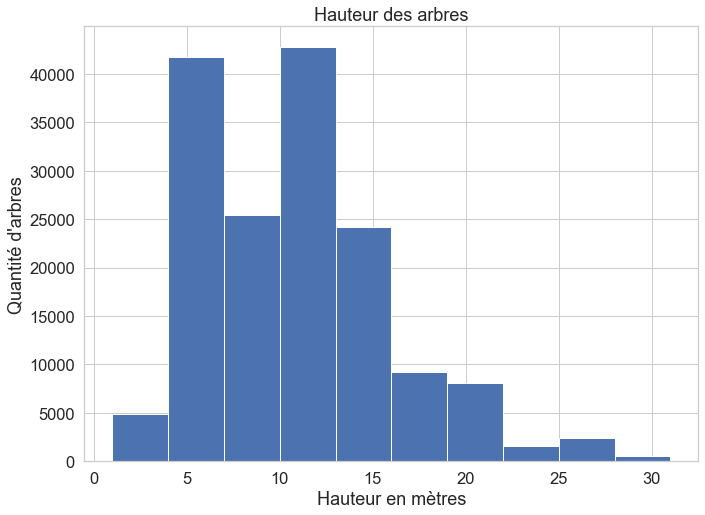

In [48]:
df_circ = df_clean.circonference_cm
df_hauteur = df_clean.hauteur_m
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
df_hauteur.hist(bins=10)
plt.xlabel("Hauteur en mètres")
plt.ylabel("Quantité d'arbres")
plt.title("Hauteur des arbres")

Text(0.5, 1.0, 'Circonférence des arbres')

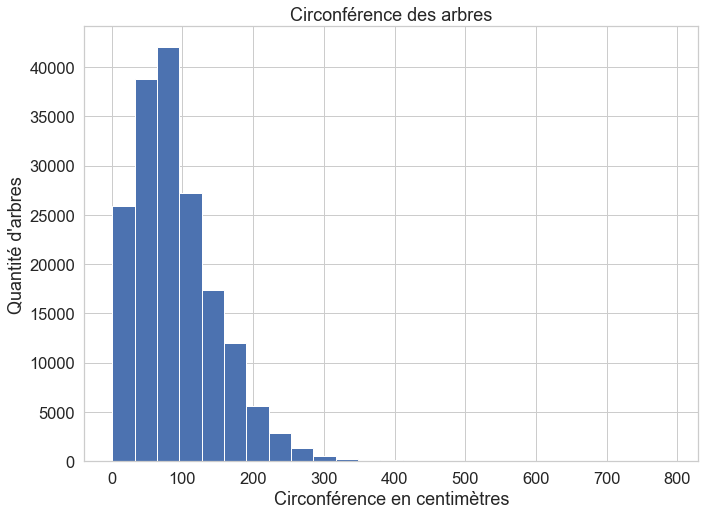

In [49]:
df_circ.hist(bins=25)
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
plt.xlabel("Circonférence en centimètres")
plt.ylabel("Quantité d'arbres")
plt.title("Circonférence des arbres")

### Variables qualitatives

In [50]:
var_qual = ["domanialite", "arrondissement", "libelle_francais", "stade_developpement", "remarquable"]
df_clean[[col for col in var_qual]].describe()

domanialite   arrondissement libelle_francais stade_developpement  \
count       200136           200137           198640              163185   
unique           9               25              192                   4   
top     Alignement  PARIS 15E ARRDT          Platane                   A   
freq        104949            17151            42508               69035   

       remarquable  
count       200137  
unique           2  
top          False  
freq        199953

#### Variables qualitiatives ordinales (stade de développement)

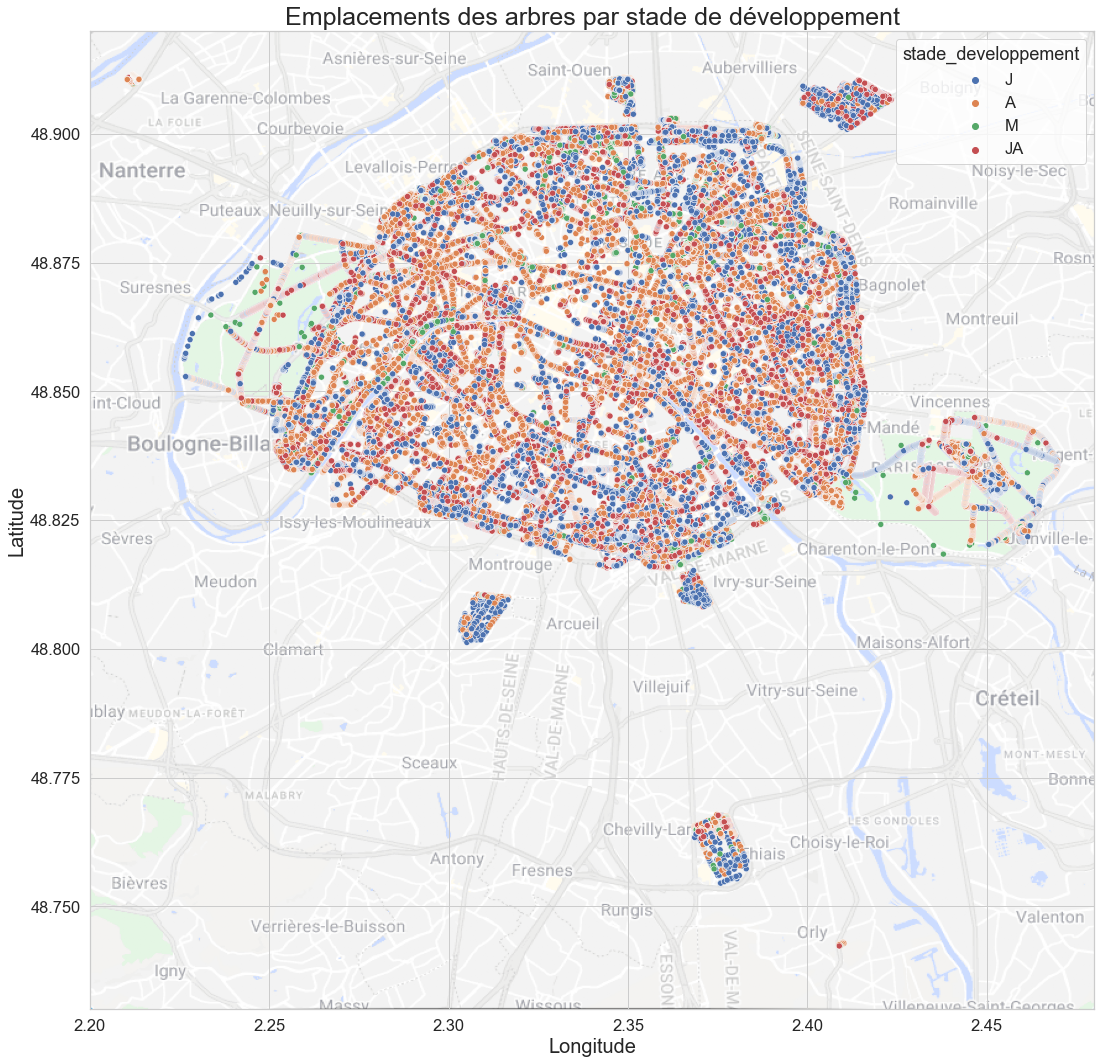

In [51]:
fig = plt.figure(figsize=(18,18))
img = plt.imread("paris.PNG")
ax = sns.scatterplot(data=df_clean,
                x="geo_point_2d_b",
                y="geo_point_2d_a",
                hue='stade_developpement')

plt.title("Emplacements des arbres par stade de développement", size=25)
plt.xlabel("Longitude", size=20)
plt.ylabel("Latitude", size=20)

BBox = [2.20, 2.48, 48.73, 48.92]

ax.imshow(img, aspect='auto', extent=BBox)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

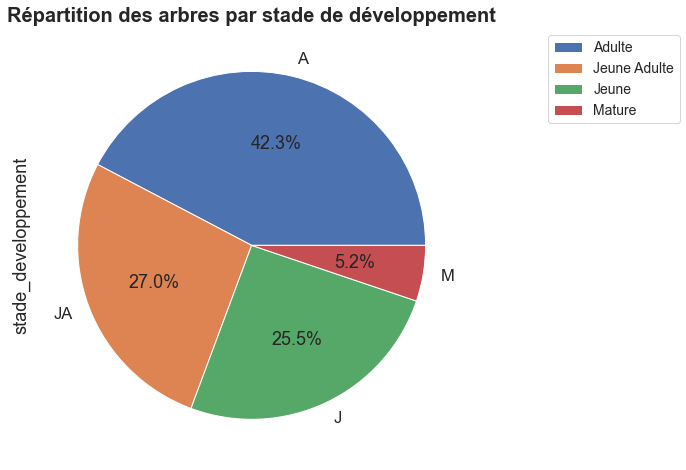

In [52]:
df_clean.stade_developpement.value_counts().plot.pie(autopct='%1.1f%%')
sns.set(rc={'figure.figsize':(15,8)}, font_scale=1.5, style='whitegrid')

plt.legend(labels=["Adulte", "Jeune Adulte", "Jeune", "Mature"], bbox_to_anchor =(1, 0, 0.5, 1), fontsize=14)
plt.title("Répartition des arbres par stade de développement", loc='center',fontsize="20", fontweight='bold')
plt.show

#### Variables qualitatives nominales (arondissement, libellé français, domanialité, remarquable)

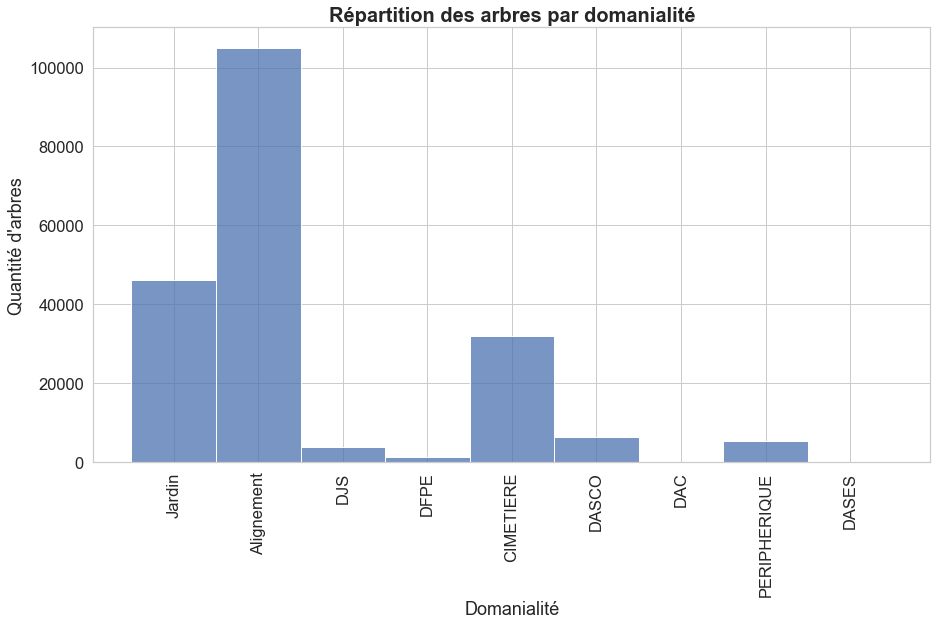

In [53]:
sns.histplot(data=df_clean,x="domanialite")
plt.xticks(rotation=90)
plt.xlabel("Domanialité")
plt.ylabel("Quantité d'arbres")
plt.title("Répartition des arbres par domanialité", loc='center',fontsize="20", fontweight='bold')
plt.show()

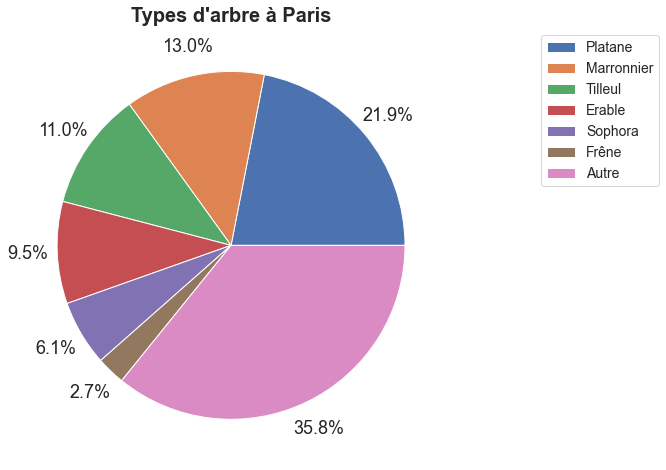

In [54]:
df_lf = df_clean.groupby(["libelle_francais"])["id"].count().sort_values(ascending=False).to_frame(name="quantite").reset_index()
autres=df_lf[7:]["quantite"].sum()
df_lf = df_lf[:7]

new_row = {'autres':autres}
df_lf["libelle_francais"][6] = 'Autre'
df_lf["quantite"][6] = autres

count = df_lf["quantite"]
lf = df_lf["libelle_francais"]

pie = plt.pie(count, autopct='%.1f%%',pctdistance=1.17)
plt.legend(labels=lf, bbox_to_anchor =(1, 0, 0.5, 1), fontsize=14)
plt.title("Types d'arbre à Paris", loc='center',fontsize="20", fontweight='bold')


plt.show()

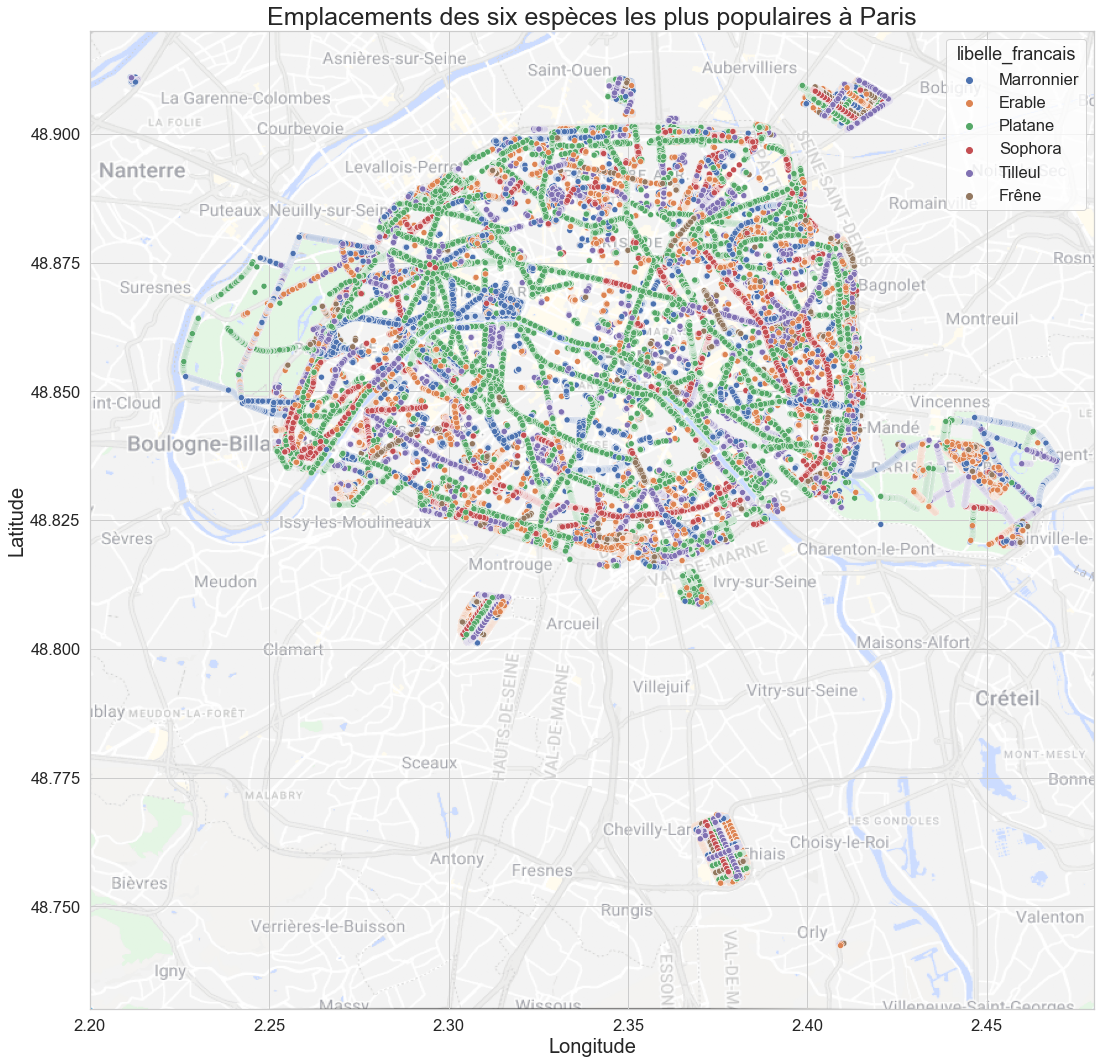

In [55]:
allowed_vals = ["Platane", "Marronnier", "Tilleul", "Erable", "Sophora", "Frêne"]

df_lf_autres = df_clean
df_lf_autres.loc[~df_lf_autres["libelle_francais"].isin(allowed_vals), "libelle_francais"] = np.nan

fig = plt.figure(figsize=(18,18))
img = plt.imread("paris.PNG")
ax = sns.scatterplot(data=df_lf_autres,
                x="geo_point_2d_b",
                y="geo_point_2d_a",
                hue='libelle_francais')
plt.title("Emplacements des six espèces les plus populaires à Paris", size=25)
plt.xlabel("Longitude", size=20)
plt.ylabel("Latitude", size=20)

BBox = [2.20, 2.48, 48.73, 48.92]

ax.imshow(img, aspect='auto', extent=BBox)
plt.show()

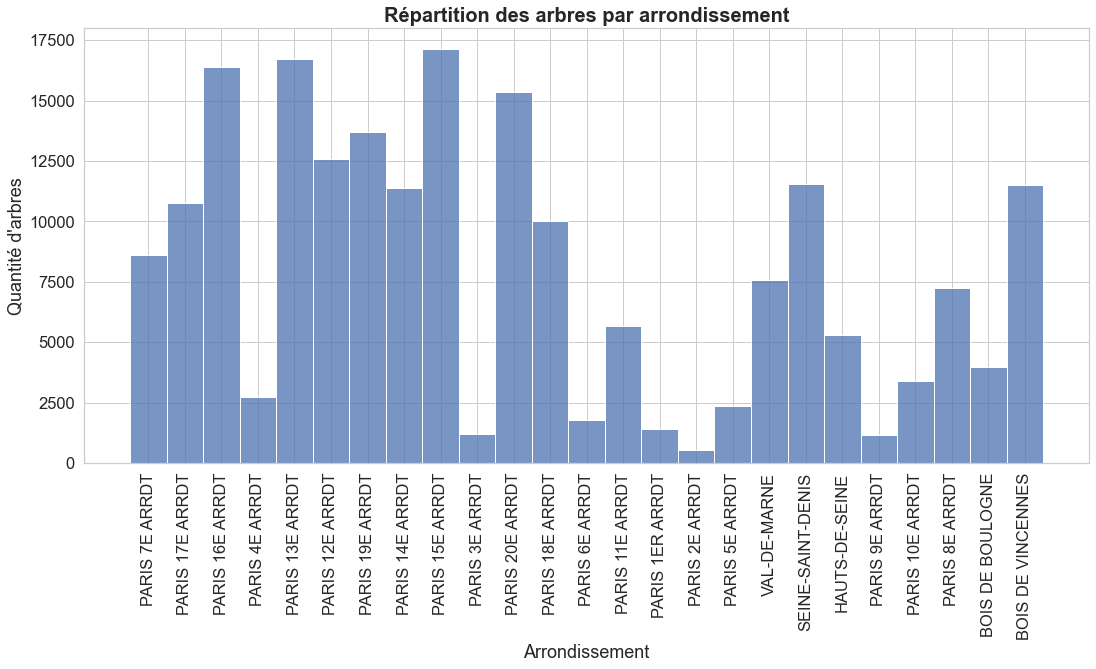

In [56]:
sns.set(rc={'figure.figsize':(18,8)}, font_scale=1.5, style='whitegrid')
sns.histplot(data=df_clean,x="arrondissement")
plt.xticks(rotation=90)
plt.xlabel("Arrondissement")
plt.ylabel("Quantité d'arbres")
plt.title("Répartition des arbres par arrondissement", loc='center',fontsize="20", fontweight='bold')
plt.show()

C:\Users\Katrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


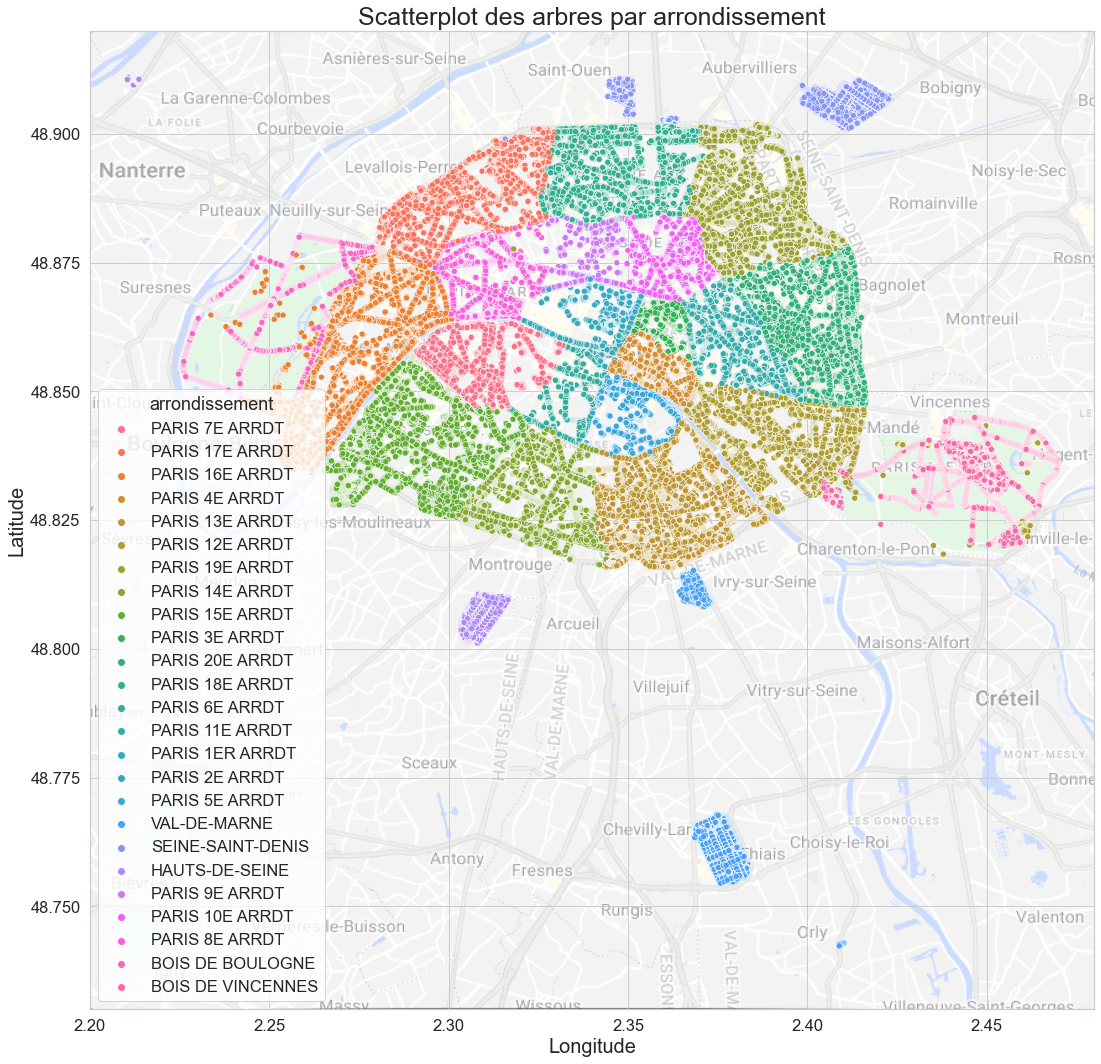

In [57]:
fig = plt.figure(figsize=(18,18))
img = plt.imread("paris.PNG")
ax = sns.scatterplot(data=df_clean,
                x="geo_point_2d_b",
                y="geo_point_2d_a",
                hue='arrondissement')

plt.title("Scatterplot des arbres par arrondissement", size=25)
plt.xlabel("Longitude", size=20)
plt.ylabel("Latitude", size=20)

BBox = [2.20, 2.48, 48.73, 48.92]

ax.imshow(img, aspect='auto', extent=BBox)
plt.show()

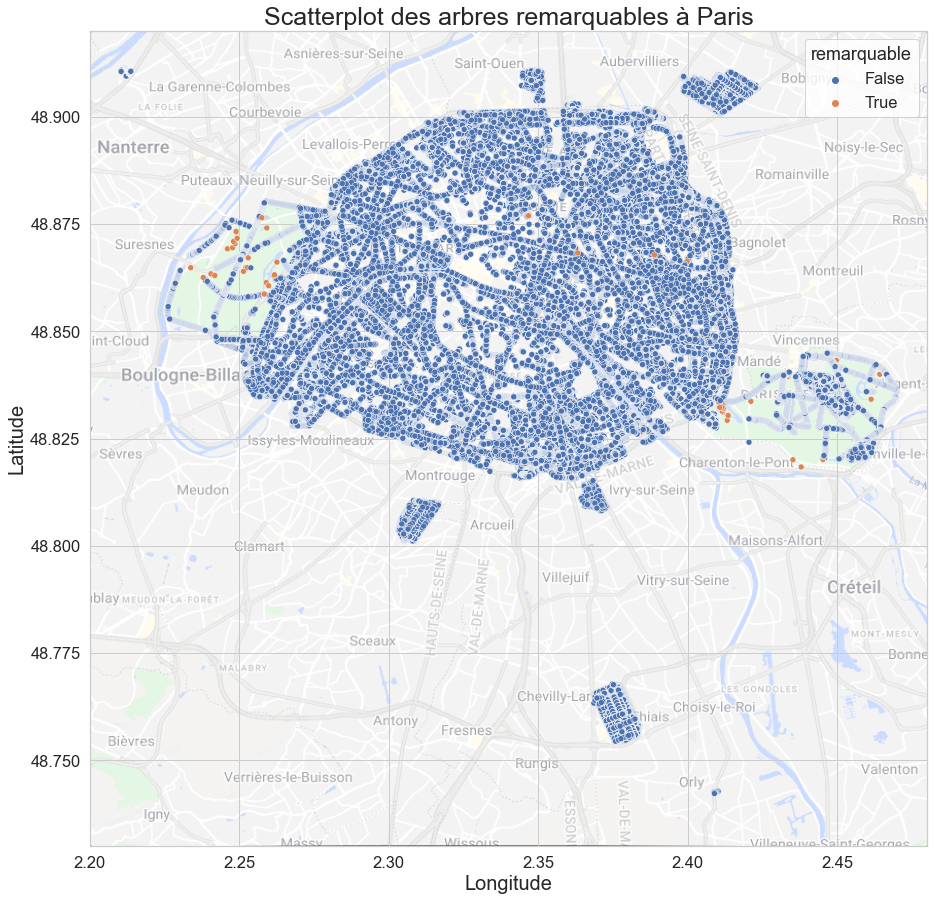

In [58]:
fig = plt.figure(figsize=(15,15))
img = plt.imread("paris.PNG")

ax = sns.scatterplot(data=df_clean,
                x="geo_point_2d_b",
                y="geo_point_2d_a",
                hue='remarquable',
                )

plt.title("Scatterplot des arbres remarquables à Paris", size=25)
plt.xlabel("Longitude", size=20)
plt.ylabel("Latitude", size=20)

BBox = [2.20, 2.48, 48.73, 48.92]

ax.imshow(img, aspect='auto', extent=BBox)
plt.show()

In [59]:
df_remarquables = df_clean.loc[df_clean["remarquable"] == True]

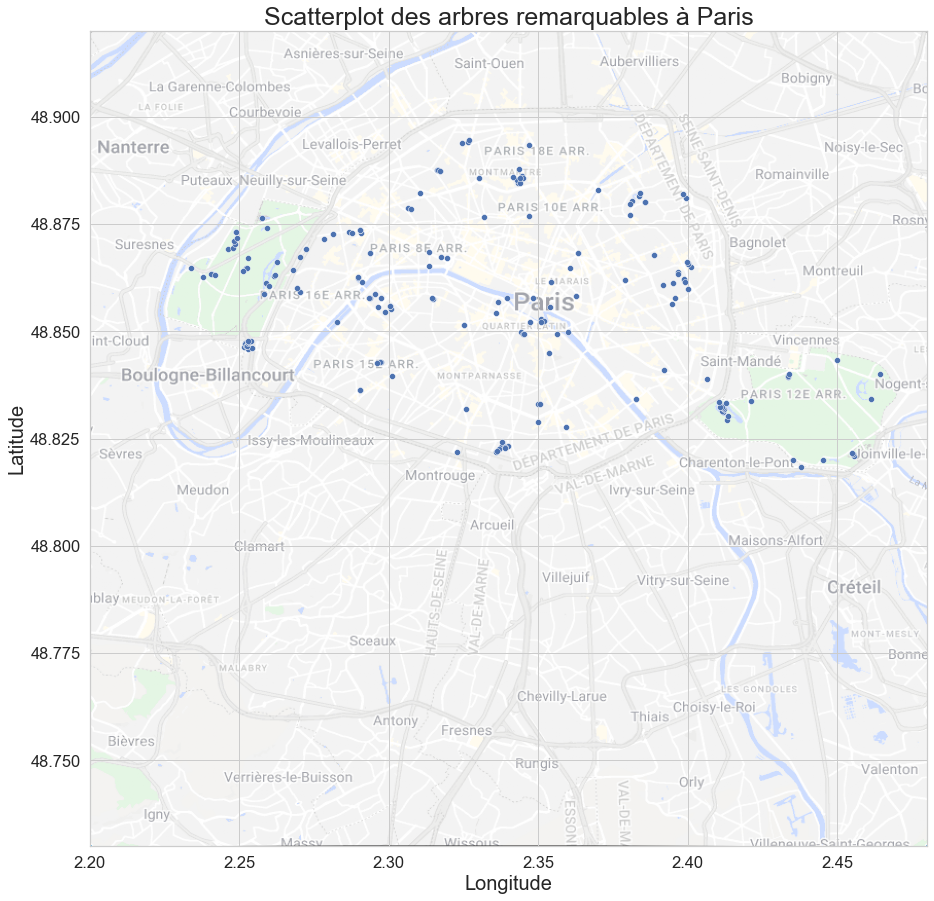

In [60]:
fig = plt.figure(figsize=(15,15))
img = plt.imread("paris.PNG")



ax = sns.scatterplot(data=df_remarquables,
                x="geo_point_2d_b",
                y="geo_point_2d_a")

plt.title("Scatterplot des arbres remarquables à Paris", size=25)
plt.xlabel("Longitude", size=20)
plt.ylabel("Latitude", size=20)

BBox = [2.20, 2.48, 48.73, 48.92]

ax.imshow(img, aspect='auto', extent=BBox)
plt.show()

## 4. Synthèse de l'analyse de données

Le jeu de données proposé est assez bien renseigné et peut être utilisé pour optimiser les tournées d'entretien des arbres à Paris.  

Qualité du jeu de données :  
* Le jeu de données à été exploitable dans le cadre de ce projet. Il y avait une quantité importante de valeurs manquantes qu'il fallait soit supprimer, soit estimer. Ce nettoyage risque de modifier les résultats de l'analyse, donc pour un projet qui demande une analyse plus poussé, il aurait fallu fournir un jeu de données plus complet. 

Les variables quantitatives, la hauteur et la circonférence, peuvent par exemple être utilisés pour : 
* Organiser les tournées d'entretien en fonction de la taille de l'arbre : faut-il déplacer l'arbre bientôt en fonction de son emplacement/proximité à un bâtiment/proximité aux autres arbres de grande taille ? 
* Les dimensions de l'arbre peuvent également être utiles en combinaison avec le stade de développement d'un arbre. Si un arbre adulte est de pétite taille, y-a-t-il une maladie en cause ? Peut-être qu'il faudra prévoir un entretien particulier pour les arbres malades ? 
* Ceci est un exemple, mais les variables quantitatives sont très utiles si on les analyse ensemble avec les variables qualitatives dans une analyse bivariée. Ces valeurs sont également précieuses afin d'imputer des valeurs manquantes, par exemple pour éstimer un stade de développement qui manque. 
* Les coordonnées géographiques sont évidemment essentielles pour planifier les tournées dans la ville de Paris. Cette variable, en combinaison avec les autres variables (en particuler les variables qualitatives comme stade de développement ou espèce), peut aider à tracer une tournée d'entretien. Les coordonnées géographiques sont également utiles, car les arbres plantés sur les routes peuvent être endommagés par les vibrations de la route, par le passage des piétons, par la pollution, par le manque de terrain, tandis que les arbres qui poussent dans des emplacements plus verts ou boisés sont moins dérangés.
  
Les variables qualitatives :
* L'espèce (dans notre analyse, le libellé français) peut être utile à savoir quels arbres ont besoin d'un entretien spécifique. Il y a certainement des espèces qui ont un entretien particuler et des autres espèces qui n'ont pas besoin de soin particulier.
* Le stade de développement d'un arbre peut aider à planifier l'arrossage par exemple, si les jeunes arbres ont besoin de plus d'eau, ou l'envers ? Ou peut-être des soins particuliers à certains âges ?
* L'arrondissement nous aide à comprendre quels quartiers ont plus d'arbres, et quels quartiers peuvent peut-être bénéficier des prochaines plantatations afin de les rendre plus verts. 
* La domanialité (jardin, alignement, etc.) est également utile à catégoriser les arbres selon les soins. Peut-être un arbre de jardin a moins besoin d'élagage que les arbres d'alignement.
  
Conseils : 
* Être méticuleux dans la saisie des données pour éviter d'avoir beaucoup de données aberrantes. Les données aberrantes modifient les résultats d'une analyse et nécessitent beaucoup de temps de nettoyage. 
* Remplir la hauteur, la circonférence et le stade de développement d'un arbre dès plantation pour que les nouveaux arbres puissent être compris dans l'analyse. 
* Manque d'informations concernant le jeu de données, par exemple, à quoi correspondent les arbres de hauteur 0 et circonférence 0 ? Ou les domanialités "DJS", "DFPE", "DASCO", etc. 